## This Notebook will be implementing the below architecture for image caption with attention

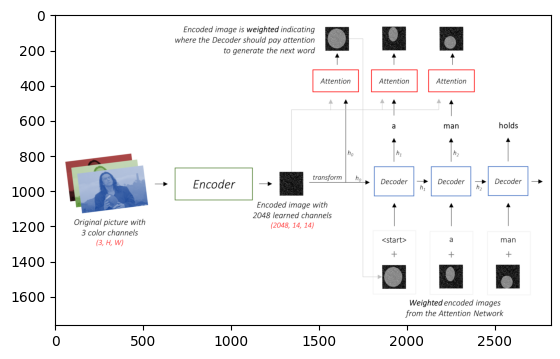

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("../input/images/model_arch.png")
plt.imshow(img)
plt.show()


In [3]:
#imports 
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# read a few elements from the dataset to see what it looks like
captions_file = "../input/flickr8k/captions.txt"
df = pd.read_csv(captions_file)
print(f"Number of captions: {len(df)}")
df.head(10)


Number of captions: 40455


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

We can see that in the dataset we have 5 captions per each image and 40,455 captions in total. 

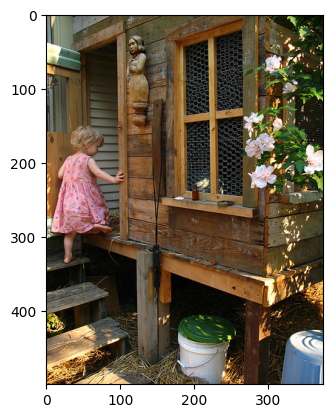

caption 1: A child in a pink dress is climbing up a set of stairs in an entry way .
caption 2: A girl going into a wooden building .
caption 3: A little girl climbing into a wooden playhouse .
caption 4: A little girl climbing the stairs to her playhouse .
caption 5: A little girl in a pink dress going into a wooden cabin .


In [5]:
# lets see one example for the first image
img_path = "../input/flickr8k/Images/"+df.iloc[0, 0]; 
img = mpimg.imread(img_path)
plt.imshow(img)
plt.show()
for i in range(5):
    print(f"caption {i+1}: {df.iloc[i,1]}")

# Prepare Dataloader and Dataset classes for Pytorch

In [6]:
# using spacy to split up the text
spacy_eng = spacy.load("en_core_web_sm")

# Prepare vocab class to tokenize caption text for training
class Vocabulary:
    def __init__(self, freq_thresh):
        self.idx_to_str = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNKNOWN>"}
        self.str_to_idx = {v:k for k,v in self.idx_to_str.items()}
        
        self.freq_thresh = freq_thresh
    
    def __len__(self): return len(self.idx_to_str)
    
    @staticmethod
    def tokenize(text):
        token_text = [token.text.lower() for token in spacy_eng.tokenizer(text)]
        return token_text
    
    def build_vocab(self, caption_list):
        frequencies = Counter()
        idx = 4 # starting 
        
        for caption in caption_list:
            for word in self.tokenize(caption):
                frequencies[word] += 1
                
                if(frequencies[word] == self.freq_thresh):
                    self.str_to_idx[word] = idx 
                    self.idx_to_str[idx] = word
                    idx += 1
    
    def word_to_idx_mapping(self, text):
        tokenized_text = self.tokenize(text)
        idx_mapping = [self.str_to_idx[token] if token in self.str_to_idx else self.str_to_idx["<UNKNOWN>"] for token in tokenized_text] 
        return idx_mapping
            

In [7]:
# test vocab class
caption = df.iloc[0,1]
v = Vocabulary(freq_thresh=1)
v.build_vocab(caption)
print(v.word_to_idx_mapping(caption))
print(v.str_to_idx)

[4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 26]
{'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNKNOWN>': 3, 'a': 4, ' ': 5, 'c': 6, 'h': 7, 'i': 8, 'l': 9, 'd': 10, 'n': 11, 'p': 12, 'k': 13, 'r': 14, 'e': 15, 's': 16, 'm': 17, 'b': 18, 'g': 19, 'u': 20, 't': 21, 'o': 22, 'f': 23, 'y': 24, 'w': 25, '.': 26}


In [8]:
# Flickr Dataset
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_thresh=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        self.vocab = Vocabulary(freq_thresh)
        self.vocab.build_vocab(self.captions.tolist()) # generate to word to idx mapping 
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None: 
            img = self.transform(img)
        
        #perform to word to idx mapping 
        word_vec = [self.vocab.str_to_idx["<START>"]]
        word_vec += self.vocab.word_to_idx_mapping(caption)
        word_vec += [self.vocab.str_to_idx["<END>"]]
        
        return img, torch.tensor(word_vec)
        

In [9]:
# the image transformation will be image resize to 224x224 since that is what the image encoder expects
transforms = T.Compose([
    T.Resize((224,224)), 
    T.ToTensor()
])

In [10]:
# function for showing tensors as images 
def show_image(img, caption= None, title=None):
    if title is not None:
        print(title)
    img_np = img.permute(1, 2, 0).cpu().numpy() 
    plt.imshow(img_np)
    plt.show()
    
    if caption is not None:
        caption_label = [dataset.vocab.idx_to_str[i] for i in cap.tolist()]
        end_idx = caption_label.index("<END>")
        caption_label=caption_label[:end_idx+1]
        print(caption_label)
       
    


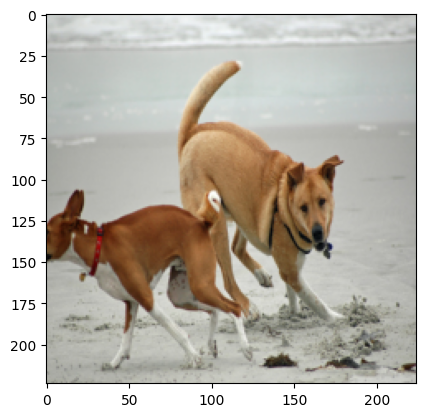

['<START>', 'two', 'different', 'breeds', 'of', 'brown', 'and', 'white', 'dogs', 'play', 'on', 'the', 'beach', '.', '<END>']


In [11]:
dataset = FlickrDataset(
    root_dir = "../input/flickr8k/Images",
    captions_file = "../input/flickr8k/captions.txt",
    transform=transforms
)

# test on one image 
img, cap = dataset[100]
show_image(img, cap)


In [12]:
# need to pad caption vectors so they are all same size for training 
class CapsCollate:
    def __init__(self, pad_idx, batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx) # use pad values function from torch
        return imgs, targets 

In [13]:
pad_idx = dataset.vocab.str_to_idx["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=15,
    num_workers=3,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
)

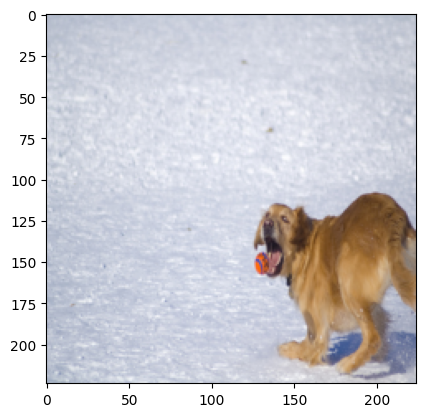

['<START>', 'a', 'dog', 'catching', 'an', 'orange', 'ball', ',', 'in', 'the', 'snow', '.', '<END>']


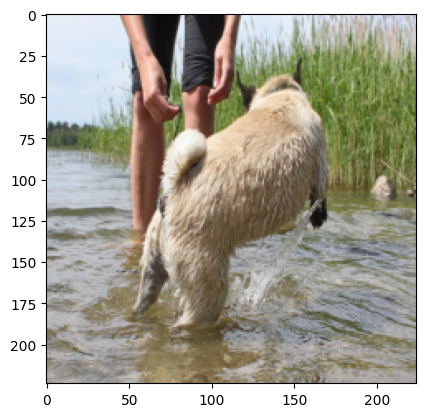

['<START>', 'the', 'white', 'dog', 'in', 'front', 'of', 'the', 'person', 'standing', 'in', 'the', 'water', 'is', 'jumping', 'up', '.', '<END>']


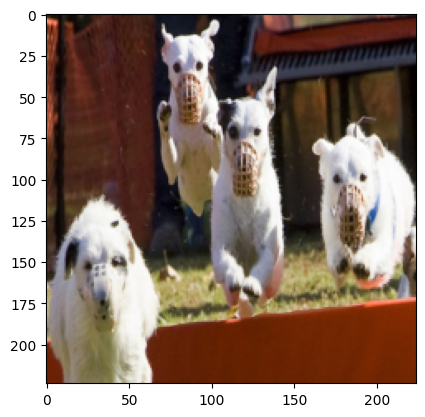

['<START>', 'four', 'white', 'dogs', 'are', 'running', 'and', 'jumping', 'with', 'masks', 'over', 'their', 'mouth', '.', '<END>']


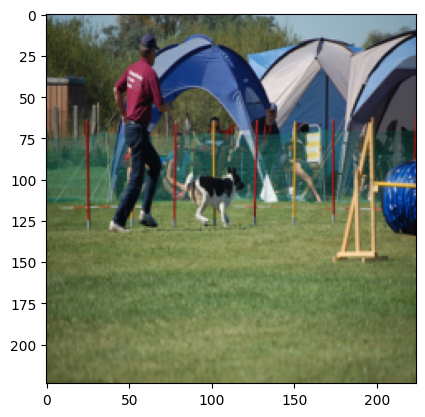

['<START>', 'a', 'man', 'runs', 'with', 'his', 'dog', 'as', 'people', 'watch', 'from', 'nearby', 'tents', '.', '<END>']


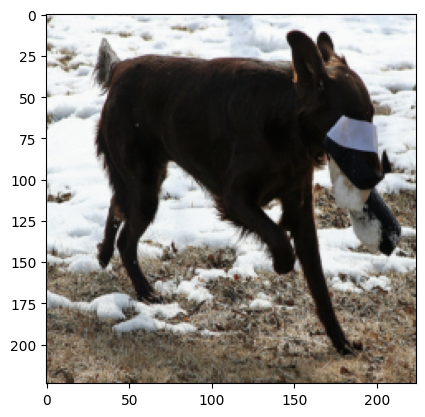

['<START>', 'a', 'dog', 'carries', 'an', 'object', 'in', 'the', 'snow', '.', '<END>']


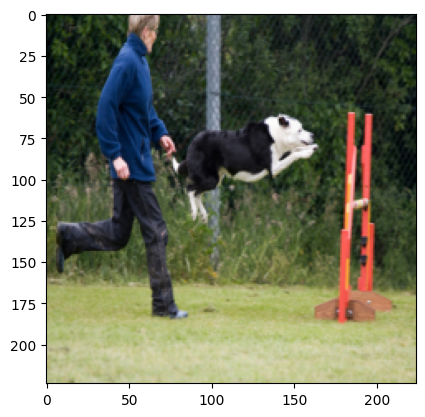

['<START>', 'the', 'dog', 'attempts', 'to', 'leap', 'over', 'the', 'post', '.', '<END>']


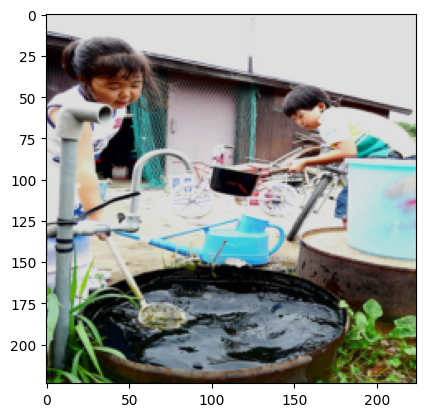

['<START>', 'two', 'children', 'cleaning', 'water', 'in', 'their', 'village', '.', '<END>']


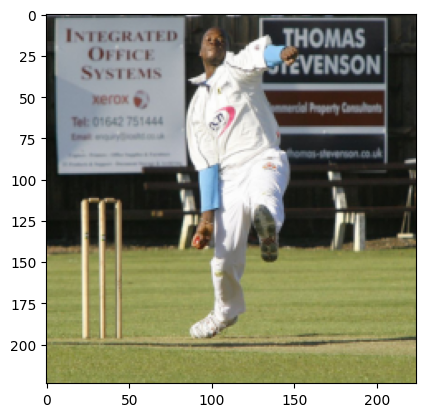

['<START>', 'a', 'man', 'getting', 'reading', 'to', 'throw', 'a', 'ball', '.', '<END>']


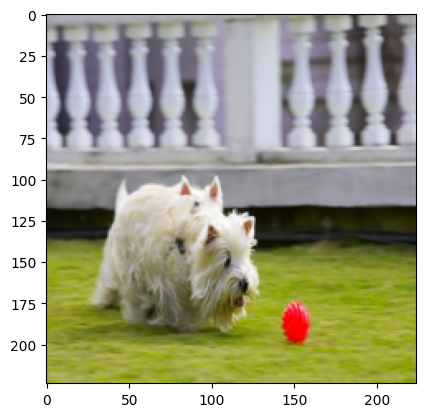

['<START>', 'two', '<UNKNOWN>', '<UNKNOWN>', 'terriers', 'chase', 'a', 'red', 'ball', '.', '<END>']


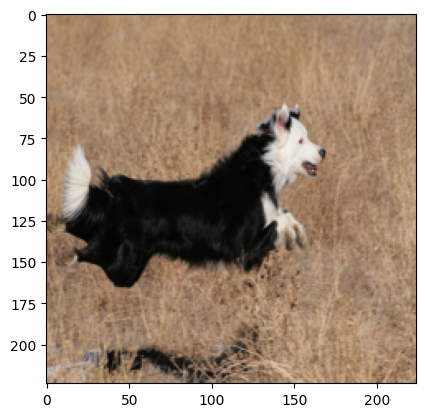

['<START>', 'a', 'black', 'and', 'white', 'dog', 'is', 'jumping', 'through', 'a', 'field', 'of', 'brown', 'grass', '.', '<END>']


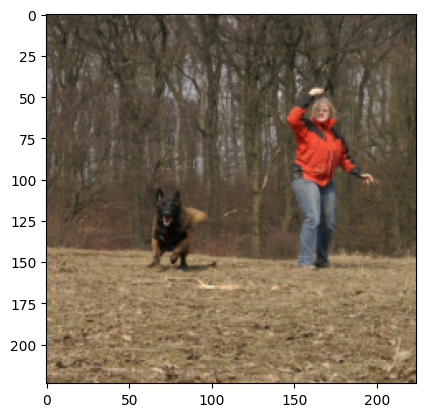

['<START>', 'outside', 'by', 'the', 'trees', ',', 'a', 'woman', 'wearing', 'jeans', 'and', 'red', 'jacket', 'throws', 'something', 'for', 'a', 'german', 'shepherd', 'to', 'chase', '.', '<END>']


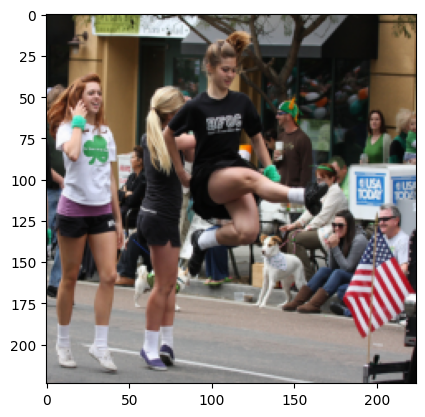

['<START>', 'a', 'woman', 'jumps', 'in', 'the', 'air', 'as', 'others', 'walk', 'behind', 'her', 'in', 'the', 'street', '.', '<END>']


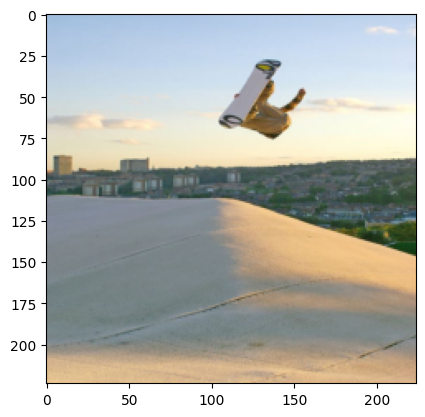

['<START>', 'a', 'snowboarder', 'is', 'in', 'midair', 'doing', 'a', 'trick', '.', '<END>']


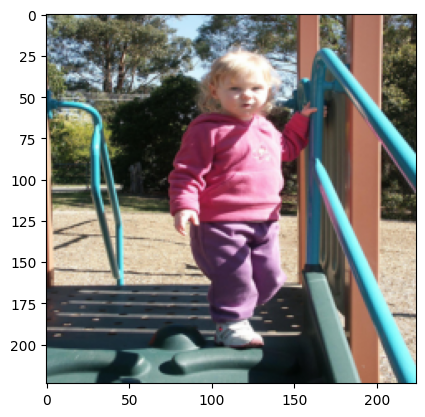

['<START>', 'a', 'female', 'toddler', 'wearing', 'a', 'pink', 'shirt', 'is', 'playing', 'on', 'a', 'playground', '.', '<END>']


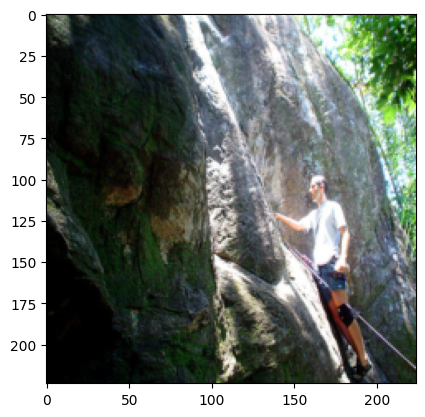

['<START>', 'a', 'climber', 'is', 'standing', 'on', 'the', 'rock', 'face', 'next', 'to', 'the', 'pink', 'rope', '.', '<END>']


In [14]:
# see the images in one batch of data 
data_iter = iter(data_loader)
batch = next(data_iter)

images, captions = batch

for i in range(len(images.tolist())):
    img, cap = images[i], captions[i]
    show_image(img,cap)
    
    

# Neural Net Architectures

In [15]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [16]:
# Neural Net Architecures adpated from: https://www.kaggle.com/code/mdteach/image-captioning-with-attention-pytorch
# the encoder will be resnet CNN arch without the classification layer
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

# Attention Network
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        
    
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.str_to_idx['<START>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.idx_to_str[predicted_word_idx.item()] == "<END>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.idx_to_str[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [17]:
embed_size=300
vocab_size=len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate=1e-3

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size=vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.str_to_idx["<PAD>"]) # ignore pad tockens for training
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s] 


# Train the model

Epoch: 1, Loss: 4.253682613372803
a man in a <UNKNOWN> . <END>


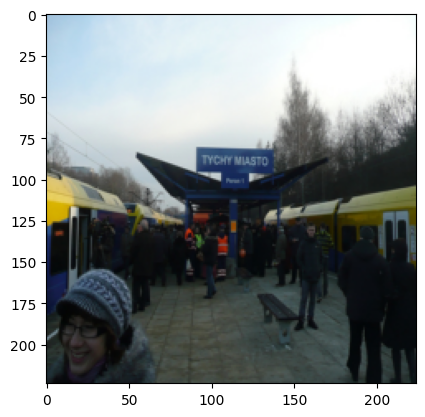

Epoch: 2, Loss: 2.5516092777252197
a little girl in a pink shirt is playing with a red toy . <END>


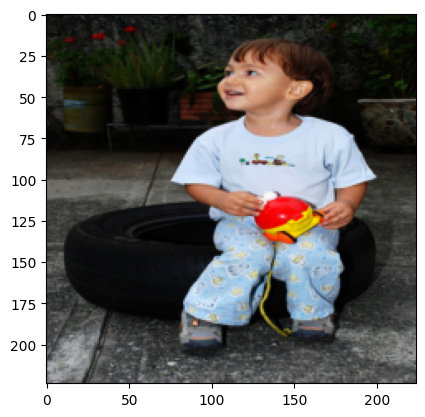

Epoch: 3, Loss: 2.5425806045532227
a brown dog is laying on its back . <END>


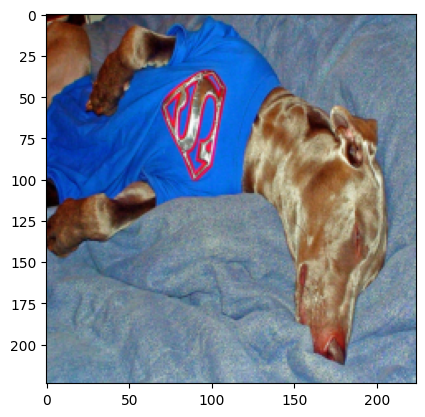

Epoch: 4, Loss: 1.9648096561431885
a man is riding a surfboard on a beach . <END>


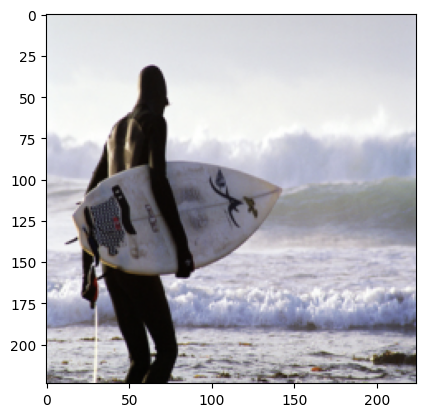

Epoch: 5, Loss: 1.9778481721878052
a man is steering a yellow <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> . <END>


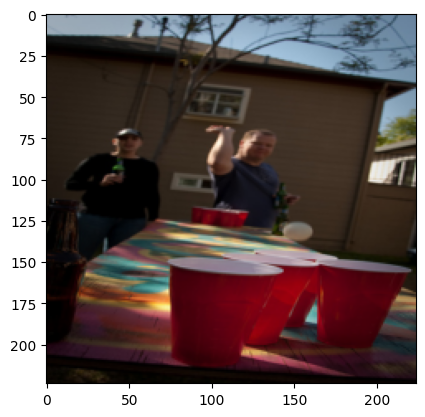

Epoch: 6, Loss: 1.6984204053878784
a dog jumps over a hurdle . <END>


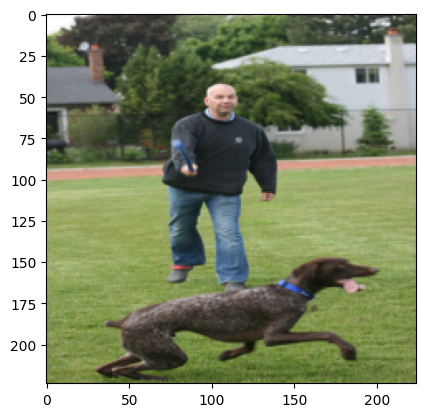

Epoch: 7, Loss: 1.813237190246582
a man in a green shirt is walking down the road . <END>


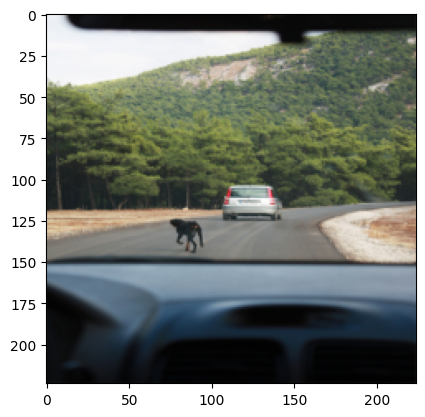

Epoch: 8, Loss: 1.4987268447875977
a woman is sitting on the bar at a bar with a beer pumps . <END>


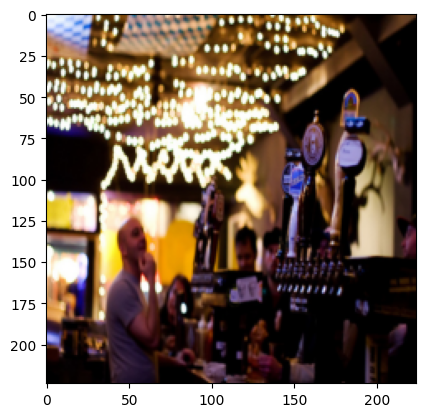

Epoch: 9, Loss: 1.5977895259857178
a child is leaping from one bed to another . <END>


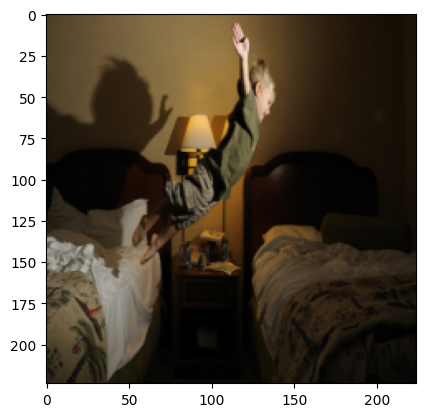

Epoch: 10, Loss: 1.2675074338912964
a child with a dirty face and holding a tree . <END>


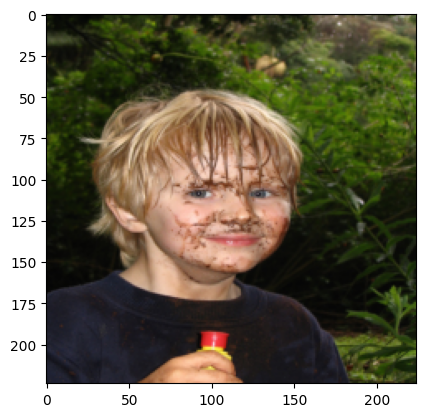

In [19]:
# train for 10 epochs & print images for progress every 100 

for epoch in range(10):
    for idx, (image,captions) in enumerate(iter(data_loader)):
        image, captions=image.to(device), captions.to(device)
        
        optimizer.zero_grad() # since grads accumilate in torch
        
        outputs,attentions=model(image,captions)
        targets=captions[:,1:]
        loss=criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        loss.backward() # backprop
        optimizer.step() #SGD with adaptive learning rates & momentum
        
        if(idx == 100):
            print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
            
            # generate caption using the model
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img, _ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0], title=caption)
            

# Above we can the performane improvement in the model between each epoch of training. The model is able to generate better and better captions. 

Let's save the model and run through few of our test images. 

In [20]:
# save the model
model_state = {
        'num_epochs':10,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
}

torch.save(model_state,'model.pth')

In [37]:
# test it on a few of own images 
test_im1 = Image.open("../input/test-images/test_im1.jpg").convert("RGB")
test_im2 = Image.open("../input/test-images/test_im2.jpg")
test_im3 = Image.open("../input/test-images/test_im3.jpg")

# format them to be able to processed by the model 
test_im1 = transforms(test_im1).unsqueeze(0)
test_im2 = transforms(test_im2).unsqueeze(0)
test_im3 = transforms(test_im3).unsqueeze(0)

print(test_im1.shape)

torch.Size([1, 3, 224, 224])


a man in a black shirt is skateboarding on a skateboard . <END>


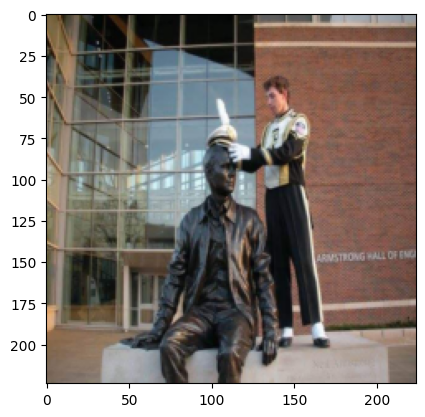

In [39]:
model.eval()
with torch.no_grad():
    img = test_im1
    features = model.encoder(img.to(device))
    caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
    caption = ' '.join(caps)
    show_image(img[0], title=caption)

a group of men in flag hats are lined with their cameras . <END>


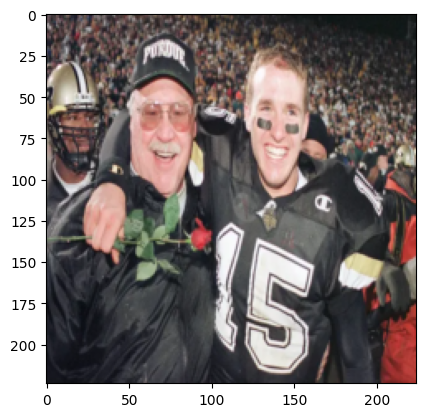

In [40]:
model.eval()
with torch.no_grad():
    img = test_im2
    features = model.encoder(img.to(device))
    caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
    caption = ' '.join(caps)
    show_image(img[0], title=caption)

a man in a blue shirt is wearing a black jacket and white <UNKNOWN> . <END>


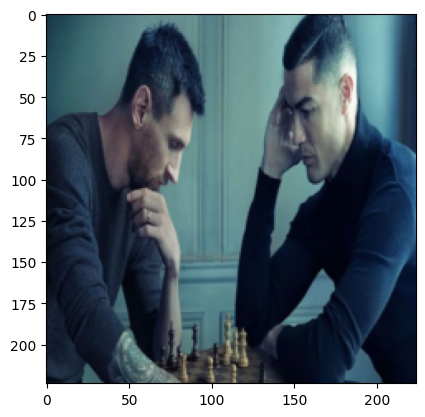

In [41]:
model.eval()
with torch.no_grad():
    img = test_im3
    features = model.encoder(img.to(device))
    caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
    caption = ' '.join(caps)
    show_image(img[0], title=caption)

## The model probably needs more epochs for training but training it is very compute intensive even though we only ran the model through 10 epochs with batch size=15 and dataset with around 40,000 training examples. 

### References 
- https://www.youtube.com/watch?v=dUzLD91Sj-o&list=PL5-TkQAfAZFbzxjBHtzdVCWE0Zbhomg7r
- https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning 
- https://karpathy.github.io/2015/05/21/rnn-effectiveness/ 
- https://www.kaggle.com/code/mdteach/image-captioning-with-attention-pytorch